# Experiment No.2
- ByBit 4 hour chart data
- threshold 0.75% 
- From 2020/03/25-2021/04/01 
- TabNet 
- simple feature engineering using differencing + some technical features from ta lib 
- No class weights

In [1]:
import numpy as np 
import pandas as pd 
import os 
import random 
from transformers import *
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm 
import torch 
import torch.nn as nn
import time
import datetime
from pytorch_tabnet.tab_model import TabNetClassifier , TabNetRegressor
import json
import ccxt
from datetime import datetime, timedelta 
import seaborn as sns
import requests 
import pandas_ta as ta
import matplotlib.pyplot as plt 
from lightgbm import LGBMClassifier  
from sklearn.utils.class_weight import compute_class_weight

PyTorch version 1.7.1 available.
TensorFlow version 2.6.2 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import json

with open('BTC_USDT-4h.json') as f:
    d = json.load(f)
    
df = pd.DataFrame(d)
df = df.rename(columns={0:"timestamp",
                        1:"open",
                        2:"high",
                        3:"low",
                        4:"close",
                        5:"volume"})

def process(df): 
    bybit = ccxt.bybit() 
    dates = df['timestamp'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = bybit.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'timestamp'})
    return df

df = process(df)

hours = []
days = [] 
months = [] 
years = [] 
for dt in tqdm(df['datetime']):
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    years.append(year) 

df['Hours'] = hours
df['Days'] = days 
df['Months'] = months 
df['Years'] = years 

df.tail(3)

100%|██████████| 4424/4424 [00:02<00:00, 1791.80it/s]


,open,high,low,close,volume,datetime,Hours,Days,Months,Years
4421,44580.0,45085.0,44535.5,44998.0,10953.692,2022-04-01 04:00:00,4,1,4,2022
4422,44998.0,45300.0,44955.0,45050.0,9896.384,2022-04-01 08:00:00,8,1,4,2022
4423,45050.0,46697.0,44650.0,46500.0,33075.924,2022-04-01 12:00:00,12,1,4,2022


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

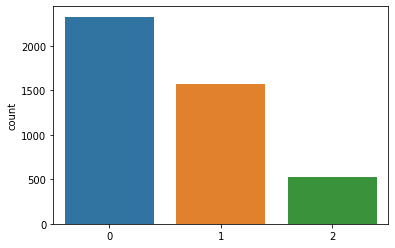

In [3]:
targets = [] 
close = df['open'].values 
high = df['high'].values 
low = df['low'].values 

threshold = 0.0075 

for i in range(close.shape[0]-1):
    high_volatility = (high[i+1]-close[i]) / close[i] 
    low_volatility = (low[i+1]-close[i]) / close[i] 
    if high_volatility >= threshold:
        targets.append(0) 
    elif low_volatility <= -threshold:
        targets.append(1) 
    else:
        targets.append(2) # do not trade 
        
        
sns.countplot(targets) 

In [4]:
targets.append(None) 

df['Targets'] = targets 

df.tail()

,open,high,low,close,volume,datetime,Hours,Days,Months,Years,Targets
4419,45590.5,45854.0,45110.0,45511.0,9912.465,2022-03-31 20:00:00,20,31,3,2022,1.0
4420,45511.0,45639.0,44202.0,44580.0,29709.921,2022-04-01 00:00:00,0,1,4,2022,1.0
4421,44580.0,45085.0,44535.5,44998.0,10953.692,2022-04-01 04:00:00,4,1,4,2022,0.0
4422,44998.0,45300.0,44955.0,45050.0,9896.384,2022-04-01 08:00:00,8,1,4,2022,0.0
4423,45050.0,46697.0,44650.0,46500.0,33075.924,2022-04-01 12:00:00,12,1,4,2022,NaN


In [5]:
print("=== Feature Engineering ===")

# add rvi 
df['RVI'] = df.ta.rvi(lookahead=False) 

# inertia 
df['inertia'] = df.ta.inertia(lookahead=False) 

for l in range(1,24): 
    for col in ['open','high','low','close','volume']: 
        val = df[col].values 
        val_ret = [None for _ in range(l)] 
        for i in range(l, len(val)):
            if val[i-l] == 0:
                ret = 1
            else:
                ret = val[i] / val[i-l] 
            val_ret.append(ret) 
        df['{}_change_{}'.format(col, l)] = val_ret 

# ebsw 
df['ebsw'] = df.ta.ebsw() 

# rsi
df['RSI'] = df.ta.rsi() 

# rsx 
df['RSX'] = df.ta.rsx() 
 
# chaikin money flow 
df['cmf'] = df.ta.cmf() 

# holt-winter moving average  
hwma = df.ta.hwma(lookahead=False).values 
close = df['close'].values  
hwma_ret = [None] 
for i in range(1, len(close)): 
    ret = hwma[i] / close[i-1] 
    hwma_ret.append(ret) 
df['hwma_ret'] = hwma_ret

# fibonacci's weighted moving average 
df['fwma'] = df.ta.fwma(lookahead=False).values 

# add average directional movement index  
df = pd.concat([df, df.ta.adx(lookahead=False)], axis=1)

# add ultimate oscillator 
df['uo'] = df.ta.uo() 

# moving average convergence divergence
df = pd.concat([df, df.ta.macd(lookahead=False)], axis = 1) 

# bollinger bands 
df = pd.concat([df, df.ta.bbands(lookahead=False)], axis=1) 

# exponential moving averages 
df['EMA10'] = df.ta.ema(length=10)
df['EMA30'] = df.ta.ema(length=30)
df['EMA60'] = df.ta.ema(length=60) 

df = df.dropna()  
df = df.drop(columns={'datetime'})

=== Feature Engineering ===


In [6]:
train_size = int(df.shape[0]*0.9) 
train_df = df[:train_size] 
test_df = df[train_size:] 

val_size = int(df.shape[0]*0.05) 
val_df = test_df[:val_size] 
test_df = test_df[val_size:] 

train_df.shape, val_df.shape, test_df.shape

((3927, 148), (218, 148), (219, 148))

In [7]:
input_columns = [] 
for col in train_df.columns:
    if col != 'Targets':
        input_columns.append(col) 
        
X_train = train_df[input_columns].values  
Y_train = train_df['Targets'].values

X_val = val_df[input_columns].values 
Y_val = val_df['Targets'].values 

X_test = test_df[input_columns].values 
Y_test = test_df['Targets'].values 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape  

((3927, 147), (3927,), (218, 147), (218,), (219, 147), (219,))

In [8]:
class_weights = compute_class_weight(class_weight = "balanced" , 
                                     classes=np.unique(Y_train), 
                                     y = Y_train)
class_weights

array([0.63574551, 0.93700787, 2.77919321])

In [12]:
d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]} 


In [23]:
full_weights = [] 

for i in range(len(Y_train)):
    full_weights.append(d[Y_train[i][0]])

In [15]:
Y_train = Y_train.reshape((-1,1)) 
Y_val = Y_val.reshape((-1,1)) 
Y_test = Y_test.reshape((-1,1))

In [35]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

clf = TabNetMultiTaskClassifier()

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)], 
        # weights=full_weights,
        max_epochs=1000,
        patience=1000)  

Device used : cuda
epoch 0  | loss: 1.0727  | val_0_logloss: 0.94938 |  0:00:00s
epoch 1  | loss: 1.01299 | val_0_logloss: 0.94094 |  0:00:01s
epoch 2  | loss: 0.96764 | val_0_logloss: 3.55186 |  0:00:01s
epoch 3  | loss: 0.94293 | val_0_logloss: 0.98338 |  0:00:02s
epoch 4  | loss: 0.92194 | val_0_logloss: 0.95084 |  0:00:02s
epoch 5  | loss: 0.90751 | val_0_logloss: 0.96998 |  0:00:02s
epoch 6  | loss: 0.89641 | val_0_logloss: 1.0023  |  0:00:03s
epoch 7  | loss: 0.88779 | val_0_logloss: 1.0062  |  0:00:03s
epoch 8  | loss: 0.86904 | val_0_logloss: 1.39247 |  0:00:04s
epoch 9  | loss: 0.86389 | val_0_logloss: 1.34962 |  0:00:04s
epoch 10 | loss: 0.85227 | val_0_logloss: 0.99039 |  0:00:05s
epoch 11 | loss: 0.84073 | val_0_logloss: 1.05754 |  0:00:05s
epoch 12 | loss: 0.82689 | val_0_logloss: 1.1656  |  0:00:05s
epoch 13 | loss: 0.8137  | val_0_logloss: 1.13578 |  0:00:06s
epoch 14 | loss: 0.80949 | val_0_logloss: 1.09808 |  0:00:06s
epoch 15 | loss: 0.79212 | val_0_logloss: 3.06031 |

epoch 132| loss: 0.56393 | val_0_logloss: 0.70192 |  0:00:59s
epoch 133| loss: 0.56244 | val_0_logloss: 0.67407 |  0:00:59s
epoch 134| loss: 0.57019 | val_0_logloss: 0.63102 |  0:01:00s
epoch 135| loss: 0.56597 | val_0_logloss: 0.70665 |  0:01:00s
epoch 136| loss: 0.55968 | val_0_logloss: 0.61799 |  0:01:00s
epoch 137| loss: 0.55877 | val_0_logloss: 0.6296  |  0:01:01s
epoch 138| loss: 0.57643 | val_0_logloss: 0.62483 |  0:01:01s
epoch 139| loss: 0.57616 | val_0_logloss: 0.66003 |  0:01:02s
epoch 140| loss: 0.56682 | val_0_logloss: 0.71844 |  0:01:02s
epoch 141| loss: 0.56757 | val_0_logloss: 0.66129 |  0:01:03s
epoch 142| loss: 0.56331 | val_0_logloss: 0.64011 |  0:01:03s
epoch 143| loss: 0.56704 | val_0_logloss: 0.64692 |  0:01:03s
epoch 144| loss: 0.5635  | val_0_logloss: 0.64351 |  0:01:04s
epoch 145| loss: 0.57055 | val_0_logloss: 0.64884 |  0:01:04s
epoch 146| loss: 0.60197 | val_0_logloss: 0.66838 |  0:01:05s
epoch 147| loss: 0.62242 | val_0_logloss: 0.67489 |  0:01:05s
epoch 14

epoch 265| loss: 0.53072 | val_0_logloss: 0.64189 |  0:01:58s
epoch 266| loss: 0.52887 | val_0_logloss: 0.6483  |  0:01:58s
epoch 267| loss: 0.52579 | val_0_logloss: 0.63629 |  0:01:59s
epoch 268| loss: 0.53628 | val_0_logloss: 0.67211 |  0:01:59s
epoch 269| loss: 0.53344 | val_0_logloss: 0.63041 |  0:02:00s
epoch 270| loss: 0.52994 | val_0_logloss: 0.62378 |  0:02:00s
epoch 271| loss: 0.52526 | val_0_logloss: 0.64239 |  0:02:01s
epoch 272| loss: 0.52829 | val_0_logloss: 0.6249  |  0:02:01s
epoch 273| loss: 0.53224 | val_0_logloss: 0.62927 |  0:02:02s
epoch 274| loss: 0.52582 | val_0_logloss: 0.62862 |  0:02:02s
epoch 275| loss: 0.5313  | val_0_logloss: 0.60774 |  0:02:03s
epoch 276| loss: 0.52072 | val_0_logloss: 0.65524 |  0:02:03s
epoch 277| loss: 0.52582 | val_0_logloss: 0.64095 |  0:02:04s
epoch 278| loss: 0.52279 | val_0_logloss: 0.63589 |  0:02:04s
epoch 279| loss: 0.52363 | val_0_logloss: 0.64569 |  0:02:05s
epoch 280| loss: 0.51879 | val_0_logloss: 0.63787 |  0:02:06s
epoch 28

epoch 398| loss: 0.49919 | val_0_logloss: 0.69548 |  0:02:58s
epoch 399| loss: 0.49867 | val_0_logloss: 0.69377 |  0:02:58s
epoch 400| loss: 0.50078 | val_0_logloss: 0.68854 |  0:02:59s
epoch 401| loss: 0.49399 | val_0_logloss: 0.69871 |  0:02:59s
epoch 402| loss: 0.49293 | val_0_logloss: 0.69975 |  0:03:00s
epoch 403| loss: 0.49241 | val_0_logloss: 0.7035  |  0:03:00s
epoch 404| loss: 0.49108 | val_0_logloss: 0.67819 |  0:03:01s
epoch 405| loss: 0.48726 | val_0_logloss: 0.67879 |  0:03:01s
epoch 406| loss: 0.48921 | val_0_logloss: 0.69349 |  0:03:02s
epoch 407| loss: 0.48564 | val_0_logloss: 0.6909  |  0:03:02s
epoch 408| loss: 0.48999 | val_0_logloss: 0.6968  |  0:03:02s
epoch 409| loss: 0.49949 | val_0_logloss: 0.71184 |  0:03:03s
epoch 410| loss: 0.51615 | val_0_logloss: 0.67212 |  0:03:03s
epoch 411| loss: 0.53089 | val_0_logloss: 0.71449 |  0:03:04s
epoch 412| loss: 0.53468 | val_0_logloss: 0.6979  |  0:03:04s
epoch 413| loss: 0.52793 | val_0_logloss: 0.77383 |  0:03:05s
epoch 41

epoch 531| loss: 0.43608 | val_0_logloss: 0.69009 |  0:04:02s
epoch 532| loss: 0.43439 | val_0_logloss: 0.74268 |  0:04:02s
epoch 533| loss: 0.44138 | val_0_logloss: 0.71664 |  0:04:02s
epoch 534| loss: 0.42913 | val_0_logloss: 0.7247  |  0:04:03s
epoch 535| loss: 0.4345  | val_0_logloss: 0.67629 |  0:04:03s
epoch 536| loss: 0.43877 | val_0_logloss: 0.70229 |  0:04:04s
epoch 537| loss: 0.43375 | val_0_logloss: 0.74867 |  0:04:04s
epoch 538| loss: 0.43855 | val_0_logloss: 0.70713 |  0:04:05s
epoch 539| loss: 0.44512 | val_0_logloss: 0.7666  |  0:04:05s
epoch 540| loss: 0.43362 | val_0_logloss: 0.70775 |  0:04:06s
epoch 541| loss: 0.42415 | val_0_logloss: 0.75606 |  0:04:06s
epoch 542| loss: 0.42603 | val_0_logloss: 0.69613 |  0:04:07s
epoch 543| loss: 0.43033 | val_0_logloss: 0.71619 |  0:04:07s
epoch 544| loss: 0.43032 | val_0_logloss: 0.72579 |  0:04:08s
epoch 545| loss: 0.43503 | val_0_logloss: 0.7153  |  0:04:08s
epoch 546| loss: 0.43451 | val_0_logloss: 0.6714  |  0:04:08s
epoch 54

epoch 664| loss: 0.47769 | val_0_logloss: 0.7714  |  0:05:02s
epoch 665| loss: 0.49301 | val_0_logloss: 0.74396 |  0:05:02s
epoch 666| loss: 0.50911 | val_0_logloss: 0.7631  |  0:05:03s
epoch 667| loss: 0.50951 | val_0_logloss: 0.72895 |  0:05:03s
epoch 668| loss: 0.50494 | val_0_logloss: 0.69958 |  0:05:04s
epoch 669| loss: 0.50008 | val_0_logloss: 0.64677 |  0:05:04s
epoch 670| loss: 0.48643 | val_0_logloss: 0.67239 |  0:05:04s
epoch 671| loss: 0.48177 | val_0_logloss: 0.7077  |  0:05:05s
epoch 672| loss: 0.49154 | val_0_logloss: 0.70202 |  0:05:05s
epoch 673| loss: 0.47141 | val_0_logloss: 0.68118 |  0:05:06s
epoch 674| loss: 0.46197 | val_0_logloss: 0.67452 |  0:05:06s
epoch 675| loss: 0.4601  | val_0_logloss: 0.71366 |  0:05:07s
epoch 676| loss: 0.4615  | val_0_logloss: 0.70975 |  0:05:07s
epoch 677| loss: 0.45172 | val_0_logloss: 0.73993 |  0:05:08s
epoch 678| loss: 0.45561 | val_0_logloss: 0.73777 |  0:05:08s
epoch 679| loss: 0.44784 | val_0_logloss: 0.70604 |  0:05:09s
epoch 68

epoch 797| loss: 0.35004 | val_0_logloss: 0.85825 |  0:06:00s
epoch 798| loss: 0.34382 | val_0_logloss: 0.87079 |  0:06:01s
epoch 799| loss: 0.33989 | val_0_logloss: 0.88248 |  0:06:01s
epoch 800| loss: 0.34637 | val_0_logloss: 0.90504 |  0:06:02s
epoch 801| loss: 0.3391  | val_0_logloss: 0.86512 |  0:06:02s
epoch 802| loss: 0.34579 | val_0_logloss: 0.82985 |  0:06:03s
epoch 803| loss: 0.35906 | val_0_logloss: 0.83367 |  0:06:03s
epoch 804| loss: 0.35147 | val_0_logloss: 0.90852 |  0:06:03s
epoch 805| loss: 0.35779 | val_0_logloss: 0.96106 |  0:06:04s
epoch 806| loss: 0.34212 | val_0_logloss: 0.92107 |  0:06:05s
epoch 807| loss: 0.35485 | val_0_logloss: 0.88805 |  0:06:05s
epoch 808| loss: 0.33901 | val_0_logloss: 0.95223 |  0:06:06s
epoch 809| loss: 0.35849 | val_0_logloss: 0.86147 |  0:06:06s
epoch 810| loss: 0.36248 | val_0_logloss: 0.80994 |  0:06:06s
epoch 811| loss: 0.36325 | val_0_logloss: 0.80842 |  0:06:07s
epoch 812| loss: 0.36216 | val_0_logloss: 0.76582 |  0:06:07s
epoch 81

epoch 930| loss: 0.33401 | val_0_logloss: 0.9299  |  0:07:00s
epoch 931| loss: 0.31305 | val_0_logloss: 0.9641  |  0:07:00s
epoch 932| loss: 0.3072  | val_0_logloss: 0.95399 |  0:07:01s
epoch 933| loss: 0.303   | val_0_logloss: 0.95678 |  0:07:01s
epoch 934| loss: 0.30256 | val_0_logloss: 0.94458 |  0:07:02s
epoch 935| loss: 0.30081 | val_0_logloss: 1.03019 |  0:07:02s
epoch 936| loss: 0.29017 | val_0_logloss: 0.98246 |  0:07:03s
epoch 937| loss: 0.28885 | val_0_logloss: 0.95018 |  0:07:03s
epoch 938| loss: 0.28574 | val_0_logloss: 0.92443 |  0:07:03s
epoch 939| loss: 0.28896 | val_0_logloss: 0.94803 |  0:07:04s
epoch 940| loss: 0.30421 | val_0_logloss: 1.02037 |  0:07:04s
epoch 941| loss: 0.28999 | val_0_logloss: 1.03438 |  0:07:05s
epoch 942| loss: 0.28976 | val_0_logloss: 0.99244 |  0:07:05s
epoch 943| loss: 0.29679 | val_0_logloss: 0.95806 |  0:07:06s
epoch 944| loss: 0.2836  | val_0_logloss: 0.93847 |  0:07:06s
epoch 945| loss: 0.27098 | val_0_logloss: 1.01529 |  0:07:06s
epoch 94

In [36]:
cnt = 0
pred = clf.predict(X_test)[0]
for i in range(len(pred)):
    if Y_test[i] == float(pred[i]):
        cnt += 1 
        
cnt / len(pred) * 100

74.42922374429224

In [39]:
pred_numtype = [] 
for p in pred:
    pred_numtype.append(float(p)) 

In [40]:
from sklearn.metrics import f1_score

print(f1_score(Y_test, pred_numtype, average='macro'))
print(f1_score(Y_test, pred_numtype, average='micro'))
print(f1_score(Y_test, pred_numtype, average='weighted'))

0.54659210935073
0.7442922374429224
0.7024134952146289


In [41]:
clf.save_model("TabNet_ByBit_no_class_weights")

Successfully saved model at TabNet_ByBit_no_class_weights.zip


'TabNet_ByBit_no_class_weights.zip'